# Pre-processing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pycaret

In [2]:
#load dataframe
#parse datetime column
df=pd.read_csv('state_cov_weather2.csv', parse_dates=[0])
df.set_index('date', inplace= True)

In [3]:
df.head()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
date,,,,,,,,,,,,,
2020-03-01,19.58,0.3,14.18,0.3,26.24,0.0,26.42,0.0,0.0,0.0,0.0,1.0,6
2020-03-02,32.00,0.0,17.06,4.6,37.58,0.0,36.50,0.0,0.0,0.0,0.0,1.0,0
2020-03-03,44.06,2.8,39.56,0.0,51.26,3.8,55.94,0.0,0.0,0.0,0.0,1.0,1
2020-03-04,41.54,0.0,32.00,6.6,48.02,0.0,46.94,2.5,0.0,0.0,0.0,2.0,2
2020-03-05,37.04,0.0,30.02,0.0,43.16,0.0,42.98,0.0,0.0,0.0,0.0,8.0,3


In [4]:
df_vt=df.drop(columns=['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases', 'CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases', 'MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases','weekday'])

In [5]:
df_me=df.drop(columns=['VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases', 'CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases', 'MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases','weekday'])

In [6]:
df_ma=df.drop(columns=['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases', 'CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases', 'VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases','weekday'])

In [7]:
df_ct= df.drop(columns=['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases', 'VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases', 'MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases','weekday'])

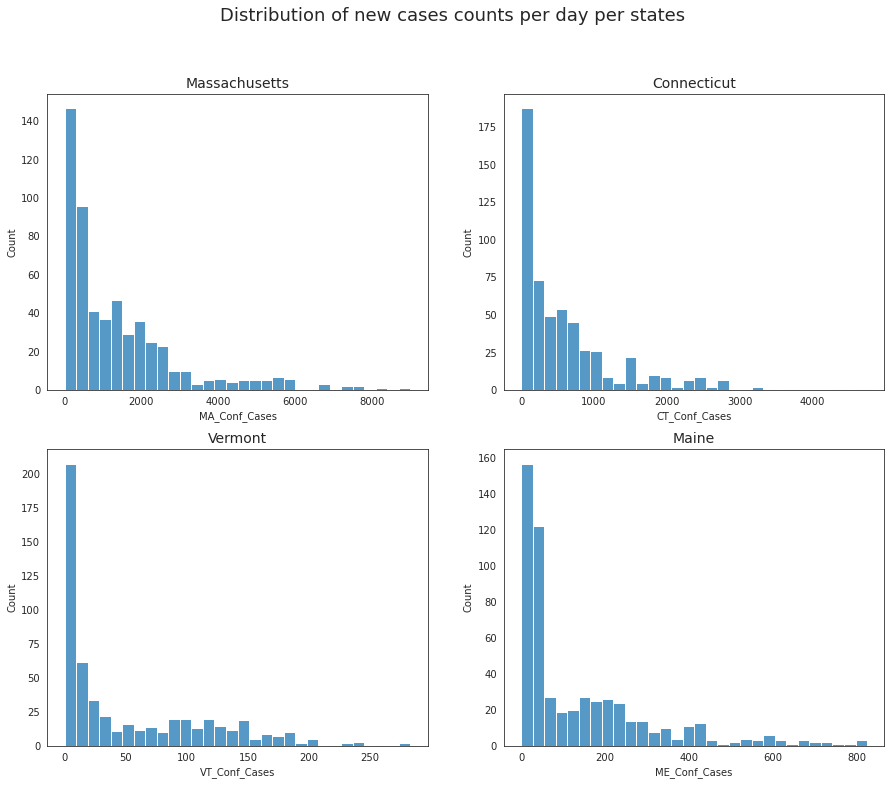

In [8]:
#Let's take a look at the distribution of case counts for MA
with sns.axes_style("white"):
    fig, axes = plt.subplots(2,2, figsize=(15,12))
    fig.suptitle('Distribution of new cases counts per day per states', fontsize=18)
    axes[0,0].set_title('Massachusetts', fontsize=14)
    axes[0,1].set_title('Connecticut', fontsize =14)
    axes[1,0].set_title('Vermont', fontsize= 14)
    axes[1,1].set_title('Maine', fontsize= 14)
    # Massachusetts
    sns.histplot(ax=axes[0, 0], x=df_ma.MA_Conf_Cases, bins=30)
    # Connecticut
    sns.histplot(ax=axes[0, 1], x=df_ct.CT_Conf_Cases, bins=30)
    # Vermont
    sns.histplot(ax=axes[1, 0], x=df_vt.VT_Conf_Cases,bins=30)
    # Maine
    sns.histplot(ax=axes[1, 1], x=df_me.ME_Conf_Cases, bins=30)

Now all of the data appears stationary and we have no more `NaN` values in any of the datasets.

***

In [9]:
# Make duplicates of datasets for processing with Pycaret:
df_vt2 = df_vt.reset_index()
df_ct2 = df_ct.reset_index()
df_me2 = df_me.reset_index()
df_ma2 = df_ma.reset_index()

In [10]:
df_ma3 = df_ma2
df_ct3 = df_ct2
df_me3 = df_me2
df_vt3 = df_vt2

In [11]:
df_list = [df_ct3, df_ma3, df_me3, df_vt3]

In [12]:
# Add 'day_of_week' and 'day_of_year' columns to each dataframe
for df in df_list:
    df['day_of_week'] = [i.dayofweek for i in df['date']]
    df['day_of_year'] = [i.dayofyear for i in df['date']]
    df['Year'] =[i.year for i in df['date']]
    df['Month'] = [i.month for i in df['date']]
    df['Day'] = [i.day for i in df['date']]

# US Census Bureau state populations
* Massachusetts: 7,029,917 
* Vermont: 643,077	
* Connecticut: 3,605,944	
* Maine: 1,362,359

Source: [U.S. Census Bureau](https://www.census.gov/quickfacts/fact/table/VT,CT,MA,ME/PST045219) April 1, 2020 Census.

Because some states are very densely populated, while others are much more sparsely populated, I'll calculate confirmed Covid cases as a percentage of overall population. 

In order to do this, I'll divide by the appropriate state's total population (as per the April 1, 2020 U.S. Census Bureau), and multiply by 100,000 for ten thousandths of a percent. 

In [13]:
df_ma3['new_case_percent_pop*'] = (df_ma3['MA_Conf_Cases'] / 70.29917)

In [14]:
df_ct3['new_case_percent_pop*'] = (df_ct3['CT_Conf_Cases'] / 36.05944)

In [15]:
df_me3['new_case_percent_pop*'] = (df_me3['ME_Conf_Cases'] / 13.62359)

In [16]:
df_vt3['new_case_percent_pop*'] = (df_vt3['VT_Conf_Cases'] / 6.43077)

Try the model using new cases as ten thousandths of a percent of population, rather than count.

## Using the mean as a baseline prediction model

#### Massachusetts

In [17]:
# Create features
X_ma, y_ma = df_ma3.drop('MA_Conf_Cases', axis =1), df_ma3.MA_Conf_Cases
# Make test and training split
X_train_ma, X_test_ma, y_train_ma, y_test_ma = train_test_split(X_ma, y_ma, random_state=42)
dummy_mean_ma = DummyRegressor(strategy='mean')
# "Train" dummy regressor
dummy_mean_ma.fit(X_train_ma, y_train_ma)
# Get R-squared score
score_mean_ma = dummy_mean_ma.score(X_test_ma, y_test_ma) 
print("The accuracy score of using the mean to predict Massachusetts' COVID19 cases is:", score_mean_ma)

The accuracy score of using the mean to predict Massachusetts' COVID19 cases is: -0.05518748553393005


#### Connecticut

In [18]:
# Create features
X_ct, y_ct = df_ct3.drop('CT_Conf_Cases', axis =1), df_ct3.CT_Conf_Cases
# Make test and training split
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(X_ct, y_ct, random_state=42)
# Create a dummy regressor
dummy_mean_ct = DummyRegressor(strategy='mean')
# "Train" dummy regressor
dummy_mean_ct.fit(X_train_ct, y_train_ct)
# Get R-squared score
score_mean_ct = dummy_mean_ct.score(X_test_ct, y_test_ct) 
print("The accuracy score of using the mean to predict Connecticut's COVID19 cases is:", score_mean_ct)

The accuracy score of using the mean to predict Connecticut's COVID19 cases is: -0.02142347120418564


#### Vermont

In [19]:
# Create features
X_vt, y_vt = df_vt3.drop('VT_Conf_Cases', axis = 1), df_vt3.VT_Conf_Cases
# Make test and training split
X_train_vt, X_test_vt, y_train_vt, y_test_vt = train_test_split(X_vt, y_vt, random_state=42)
# Create a dummy regressor
dummy_mean_vt = DummyRegressor(strategy='mean')
# "Train" dummy regressor
dummy_mean_vt.fit(X_train_vt, y_train_vt)
# Get R-squared score
score_mean_vt = dummy_mean_vt.score(X_test_vt, y_test_vt) 
print("The accuracy score of using the mean to predict Vermont's COVID19 cases is:", score_mean_vt)

The accuracy score of using the mean to predict Vermont's COVID19 cases is: -0.026382978219730235


#### Maine

In [20]:
# Create features
X_me, y_me = df_me3.drop('ME_Conf_Cases', axis =1), df_me3.ME_Conf_Cases
# Make test and training split
X_train_me, X_test_me, y_train_me, y_test_me = train_test_split(X_me, y_me, random_state=42)
# Create a dummy regressor
dummy_mean_me = DummyRegressor(strategy='mean')
# "Train" dummy regressor
dummy_mean_me.fit(X_train_me, y_train_me)
# Get R-squared score
score_mean_me = dummy_mean_me.score(X_test_me, y_test_me) 
print("The accuracy score of using the mean to predict Maine's COVID19 cases is:", score_mean_me)

The accuracy score of using the mean to predict Maine's COVID19 cases is: -0.06608993725524748


## Create a baseline model for optimization

In [21]:
from pycaret.regression import *
all_results=[]
df_subset = df_ma3

# initialize setup from pycaret.regression
s = setup(df_subset, target = 'new_case_percent_pop*', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'MA_Conf_Cases', 'MA_PRCP(mm)'],
            numeric_features = ['day_of_year', 'Year', 'MA_Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week'],
            silent = True, verbose = False, session_id = 123,
            normalize=False)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str("MA")
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
best_model

In [22]:
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
catboost,CatBoost Regressor,4.2127,47.9263,6.8324,0.899,0.4456,2.4854,0.2533,MA


In [23]:
all_results=[]
df_subset = df_ct3

# initialize setup from pycaret.regression
s = setup(df_subset, target = 'new_case_percent_pop*', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'CT_Conf_Cases', 'CT_PRCP(mm)'],
            numeric_features = ['day_of_year', 'Year', 'CT_Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week'],
            silent = True, verbose = False, session_id = 123,
            normalize=True)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str("CT")
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
best_model

In [24]:
concat_results = pd.concat([pd.concat(all_results, axis=0), concat_results], axis=0)
concat_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
catboost,CatBoost Regressor,5.3463,81.2217,8.9046,0.802,0.5573,1.3929,0.3100,CT
catboost,CatBoost Regressor,4.2127,47.9263,6.8324,0.899,0.4456,2.4854,0.2533,MA


In [25]:
all_results=[]
df_subset = df_vt3

# initialize setup from pycaret.regression
s = setup(df_subset, target = 'new_case_percent_pop*', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'VT_Conf_Cases', 'VT_PRCP(mm)'],
            numeric_features = ['day_of_year', 'Year', 'VT_Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week'],
            silent = True, verbose = False, session_id = 123,
            normalize=True)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str("VT")
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
best_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [26]:
concat_results = pd.concat([pd.concat(all_results, axis=0), concat_results], axis=0)
concat_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
rf,Random Forest Regressor,2.4441,16.8126,4.0877,0.8185,0.3689,0.7089,0.0800,VT
catboost,CatBoost Regressor,5.3463,81.2217,8.9046,0.8020,0.5573,1.3929,0.3100,CT
catboost,CatBoost Regressor,4.2127,47.9263,6.8324,0.8990,0.4456,2.4854,0.2533,MA


In [27]:
all_results=[]
df_subset = df_me3

# initialize setup from pycaret.regression
s = setup(df_subset, target = 'new_case_percent_pop*', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'ME_Conf_Cases', 'ME_PRCP(mm)'],
            numeric_features = ['day_of_year', 'Year','ME_Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week'],
            silent = True, verbose = False, session_id = 123,
            normalize=True)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str("ME")
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
best_model

In [28]:
concat_results = pd.concat([pd.concat(all_results, axis=0), concat_results], axis=0)
concat_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
catboost,CatBoost Regressor,3.0924,29.6239,5.3640,0.7983,0.4412,0.9200,0.2100,ME
rf,Random Forest Regressor,2.4441,16.8126,4.0877,0.8185,0.3689,0.7089,0.0800,VT
catboost,CatBoost Regressor,5.3463,81.2217,8.9046,0.8020,0.5573,1.3929,0.3100,CT
catboost,CatBoost Regressor,4.2127,47.9263,6.8324,0.8990,0.4456,2.4854,0.2533,MA


***

**********************

*************************

# Cross-correlation (time-lag)

#### Massachusetts

In [29]:
df_ma4=df_ma3

In [30]:
temp_cov_lags = {'1_wk':7, '1.5_wks':10, '2_wks':14, '3_wks':21, '4_wks':28}

In [31]:
for key, value in temp_cov_lags.items():
    df_ma4[key] = df_ma4['MA_Conf_Cases'].shift(value, axis=0)

In [ ]:
#df_ma4['cases_lag_2wks'] = df_ma4['MA_Conf_Cases'].shift(14, axis=0)

In [32]:
df_ma4 = df_ma4.dropna()

In [ ]:
#df_ma4 = df_ma4.drop(['MA_PRCP(mm)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1)

In [ ]:
#df_ma4.corr()

In [33]:
df_ma4.tail(25)

,date,MA_Avg_Temp(F),MA_PRCP(mm),MA_Conf_Cases,day_of_week,day_of_year,Year,Month,Day,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
531,2021-08-18,77.90,0.0,1579.0,2,230,2021,8,18,22.461147,1440.0,884.0,1032.0,660.0,525.0
532,2021-08-19,77.36,14.5,1576.0,3,231,2021,8,19,22.418472,1367.0,884.0,1171.0,905.0,542.0
533,2021-08-20,73.94,0.3,1533.0,4,232,2021,8,20,21.806801,1298.0,445.0,1206.0,931.0,624.0
534,2021-08-21,77.00,0.0,1139.0,5,233,2021,8,21,16.202183,1031.0,1440.0,884.0,702.0,424.0
535,2021-08-22,73.40,17.5,1139.0,6,234,2021,8,22,16.202183,1031.0,1367.0,884.0,702.0,424.0
536,2021-08-23,75.92,0.3,1139.0,0,235,2021,8,23,16.202183,1031.0,1298.0,884.0,702.0,424.0
537,2021-08-24,76.46,31.8,533.0,1,236,2021,8,24,7.581882,489.0,1031.0,445.0,367.0,277.0
538,2021-08-25,78.44,0.0,1495.0,2,237,2021,8,25,21.266254,1579.0,1031.0,1440.0,1032.0,660.0
539,2021-08-26,80.96,0.0,1891.0,3,238,2021,8,26,26.899322,1576.0,1031.0,1367.0,1171.0,905.0
540,2021-08-27,80.42,0.0,1656.0,4,239,2021,8,27,23.556466,1533.0,489.0,1298.0,1206.0,931.0


In [83]:
df_ma4['MA_Avg_Temp(F)'].autocorr(21)

0.7815162502254257

In [35]:
df_ma4['MA_Conf_Cases'].autocorr(14)

0.8400559242977055

In [73]:
ma_corr = df_ma4.corr().drop(['MA_PRCP(mm)', 'MA_Avg_Temp(F)', 'new_case_percent_pop*','day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1)
ma_corr.rename(columns={'MA_Conf_Cases': 'cases_lag_0'}, inplace=True)
ma_corr

,cases_lag_0,1_wk,1.5_wks,2_wks,3_wks,4_wks
MA_Avg_Temp(F),-0.665619,-0.700930,-0.701341,-0.703916,-0.696414,-0.672984
MA_PRCP(mm),0.005258,-0.011977,-0.022478,-0.014780,-0.032449,-0.048845
MA_Conf_Cases,1.000000,0.916362,0.788371,0.835688,0.745091,0.638274
day_of_week,0.031086,0.047477,-0.012123,0.048667,0.047003,0.049259
day_of_year,-0.080500,-0.213485,-0.249581,-0.308601,-0.413416,-0.519410
Year,0.078303,0.155413,0.177140,0.215841,0.286195,0.358349
Month,-0.081115,-0.216741,-0.254779,-0.315806,-0.420601,-0.521437
Day,-0.024466,-0.002075,0.017079,0.035641,0.032746,-0.021849
new_case_percent_pop*,1.000000,0.916362,0.788371,0.835688,0.745091,0.638274
1_wk,0.916362,1.000000,0.829827,0.919334,0.838120,0.747557


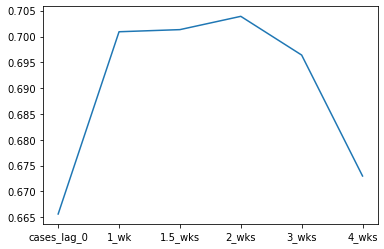

In [74]:
abs(ma_corr.loc['MA_Avg_Temp(F)']).plot()
plt.show()

In [57]:
#ma_corr.loc['MA_Conf_Cases', '1_wk':].plot()
#plt.show()

****

In [37]:
df_ma5=df_ma3

In [38]:
df_ma5.drop(columns=['1_wk', '1.5_wks', '2_wks', '3_wks', '4_wks'], inplace=True)

In [39]:
df_ma5

,date,MA_Avg_Temp(F),MA_PRCP(mm),MA_Conf_Cases,day_of_week,day_of_year,Year,Month,Day,new_case_percent_pop*
0,2020-03-01,26.42,0.0,1.0,6,61,2020,3,1,0.014225
1,2020-03-02,36.50,0.0,1.0,0,62,2020,3,2,0.014225
2,2020-03-03,55.94,0.0,1.0,1,63,2020,3,3,0.014225
3,2020-03-04,46.94,2.5,2.0,2,64,2020,3,4,0.028450
4,2020-03-05,42.98,0.0,8.0,3,65,2020,3,5,0.113799
...,...,...,...,...,...,...,...,...,...,...
551,2021-09-08,71.96,0.0,1475.0,2,251,2021,9,8,20.981756
552,2021-09-09,70.88,8.1,2407.0,3,252,2021,9,9,34.239380
553,2021-09-10,68.54,7.6,1873.0,4,253,2021,9,10,26.643273
554,2021-09-11,59.99,0.3,0.0,5,254,2021,9,11,0.000000


In [40]:
temp_cov_lags2 = {'1_wk':-7, '1.5_wks':-10, '2_wks':-14, '3_wks':-21, '4_wks':-28}

In [41]:
for key, value in temp_cov_lags2.items():
    df_ma5[key] = df_ma5['MA_Conf_Cases'].shift(value, axis=0)

In [43]:
df_ma5.dropna(inplace=True)

In [75]:
ma_corr2 = df_ma5.corr().drop(['MA_PRCP(mm)', 'MA_Avg_Temp(F)', 'new_case_percent_pop*','day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1)
ma_corr2.rename(columns={'MA_Conf_Cases': 'cases_lag_0'}, inplace=True)
ma_corr2

,cases_lag_0,1_wk,1.5_wks,2_wks,3_wks,4_wks
MA_Avg_Temp(F),-0.628138,-0.617129,-0.604865,-0.591901,-0.546742,-0.497032
MA_PRCP(mm),0.009234,0.020513,0.007562,0.032721,0.022007,0.034374
MA_Conf_Cases,1.000000,0.920939,0.795222,0.839697,0.747557,0.638274
day_of_week,0.030854,0.006737,-0.056413,-0.014915,-0.024158,-0.035807
day_of_year,-0.033624,0.114326,0.169013,0.243140,0.334056,0.399573
Year,0.116197,0.020494,-0.017579,-0.064108,-0.124019,-0.168481
Month,-0.036013,0.108221,0.164077,0.236952,0.331757,0.401671
Day,-0.004890,0.041611,0.031930,0.048676,0.011518,-0.033403
new_case_percent_pop*,1.000000,0.920939,0.795222,0.839697,0.747557,0.638274
1_wk,0.920939,1.000000,0.833874,0.920121,0.838120,0.745091


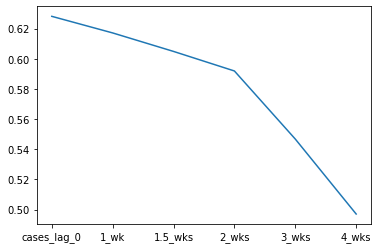

In [79]:
abs(ma_corr2.loc['MA_Avg_Temp(F)']).plot()
plt.show()

#### Connecticut

In [ ]:
df_ct4=df_ct3

In [ ]:
for key, value in temp_cov_lags.items():
    df_ct4[key] = df_ct4['CT_Conf_Cases'].shift(value, axis=0)

In [ ]:
df_ct4 = df_ct4.dropna()
df_ct4 = df_ct4.drop(['CT_PRCP(mm)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1)

In [ ]:
#df_ma4.corr()

#### Maine

In [ ]:
df_me4=df_me3

In [ ]:
for key, value in temp_cov_lags.items():
    df_me4[key] = df_me4['ME_Conf_Cases'].shift(value, axis=0)

In [ ]:
df_me4 = df_me4.dropna()
df_me4 = df_me4.drop(['ME_PRCP(mm)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1)

In [ ]:
#df_me4.corr()

#### Vermont

In [ ]:
df_vt4=df_vt3

In [ ]:
for key, value in temp_cov_lags.items():
    df_vt4[key] = df_vt4['VT_Conf_Cases'].shift(value, axis=0)

In [ ]:
df_vt4 = df_vt4.dropna()
df_vt4 = df_vt4.drop(['VT_PRCP(mm)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1)

In [ ]:
df_vt4.corr()

#### Re-run pycaret baseline models

In [ ]:
from pycaret.regression import *
all_results=[]
df_subset = df_ma4

# initialize setup from pycaret.regression
s = setup(df_subset, target = 'cases_lag_2wks', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'MA_Conf_Cases', 'new_case_percent_pop*','MA_PRCP(mm)'],
            numeric_features = ['day_of_year', 'Year', 'MA_Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week'],
            silent = True, verbose = False, session_id = 123,
            normalize=False)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str("MA")
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
best_model

In [ ]:
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

#### Connecticut

In [ ]:
df_ct4=df_ct3

In [ ]:
df_ct4['cases_lag_2wks'] = df_ct4['CT_Conf_Cases'].shift(14, axis=0)

In [ ]:
df_ct4 = df_ct4.dropna()

In [ ]:
all_results=[]
df_subset = df_ct4

# initialize setup from pycaret.regression
s = setup(df_subset, target = 'cases_lag_2wks', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'CT_Conf_Cases', 'new_case_percent_pop*','CT_PRCP(mm)'],
            numeric_features = ['day_of_year', 'Year', 'CT_Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week'],
            silent = True, verbose = False, session_id = 123,
            normalize=True)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str("CT")
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
best_model

In [ ]:
concat_results = pd.concat([pd.concat(all_results, axis=0), concat_results], axis=0)
concat_results

#### Vermont

In [ ]:
df_vt4=df_vt3

In [ ]:
df_vt4['cases_lag_2wks'] = df_vt4['VT_Conf_Cases'].shift(14, axis=0)

In [ ]:
df_vt4 = df_vt4.dropna()

In [ ]:
all_results=[]
df_subset = df_vt4

# initialize setup from pycaret.regression
s = setup(df_subset, target = 'cases_lag_2wks', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'VT_Conf_Cases', 'VT_PRCP(mm)', 'new_case_percent_pop*'],
            numeric_features = ['day_of_year', 'Year', 'VT_Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week'],
            silent = True, verbose = False, session_id = 123,
            normalize=True)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str("VT")
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
best_model

In [ ]:
concat_results = pd.concat([pd.concat(all_results, axis=0), concat_results], axis=0)
concat_results

#### Maine

In [ ]:
df_me4=df_me3

In [ ]:
df_me4['cases_lag_2wks'] = df_me4['ME_Conf_Cases'].shift(14, axis=0)

In [ ]:
df_me4 = df_me4.dropna()

In [ ]:
all_results=[]
df_subset = df_me4

# initialize setup from pycaret.regression
s = setup(df_subset, target = 'cases_lag_2wks', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'ME_Conf_Cases', 'ME_PRCP(mm)', 'new_case_percent_pop*'],
            numeric_features = ['day_of_year', 'Year', 'ME_Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week'],
            silent = True, verbose = False, session_id = 123,
            normalize=True)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str("ME")
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
best_model

In [ ]:
concat_results = pd.concat([pd.concat(all_results, axis=0), concat_results], axis=0)
concat_results

Average R2 = 0.80605